# scRNA sequencing Data Analysis
student name: Mianyong Ding
student number: r0823572

In [1]:
setwd(path.expand("~/data/jupyternotebooks/")) 

In [2]:
getwd()

[1] "/mnt/storage/r0823572/jupyternotebooks"

In [3]:
options(stringsAsFactors=FALSE)
library(Seurat)
library(dplyr)
library(Matrix)
library(SCopeLoomR)
library(IRdisplay)
library(plyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘SCopeLoomR’


The following object is masked from ‘package:base’:

    flush


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




In [4]:
dir.create(("scRNAseqnew"))
setwd("scRNAseqnew")

Warning message in dir.create(("scRNAseqnew")):
“'scRNAseqnew' already exists”


In [5]:
getwd()

[1] "/mnt/storage/r0823572/jupyternotebooks/scRNAseqnew"

# Data description
The data is generated from 1441 single human celss from four non-small lung cancer(NSCLC) cell lines (A549, H460, H1299 and Calu3) to identity the biomarkers for diagnosis of early stage lung adenocarcinoma(LUAD ) patients.
Each 400 single cells per NSCLC cell lines (A549, H460, H1299 and Calu3) were loaded to chambers of high-throughput (HT) scRNA-seq integrated fluidics circuits (IFCs). 
And four hundreds of 3'-end enriched scRNA-seq libraries per NSCLC cell line using in Fluidigm C1 systems were built. Those The illumina Nextseq 500 systems was used to sequenced these libraries.

The Read_count_matrix of scRNA seq data is from geo with the geo accession number GSE183590 and the data is orginally from the paper:Kim J, Xu Z, Marignani PA. Single-cell RNA sequencing for the identification of early-stage lung cancer biomarkers from circulating blood. NPJ Genom Med 2021 Oct 15;6(1):87. PMID: 34654834.

In [6]:
system("wget http://ftp.ncbi.nlm.nih.gov/geo/series/GSE183nnn/GSE183590/suppl/GSE183590_Read_count_matrix_05092021.txt.gz")

In [7]:
dir()

[1] "GSE183590_Read_count_matrix_05092021.txt.gz"

In [8]:
cancer_data<-read.delim('GSE183590_Read_count_matrix_05092021.txt.gz')

In [9]:
dim(cancer_data)
rownames(cancer_data) <-cancer_data$Geneid
cancer_data[1:5,1:10]

[1] 44468  1457

,Geneid,X0001,X0002,X0003,X0004,X0005,X0006,X0007,X0008,X0009
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,ENSG00000223972,0,0,0,0,0,0,0,0,0
ENSG00000227232,ENSG00000227232,0,0,0,0,0,0,0,0,0
ENSG00000268020,ENSG00000268020,0,0,0,0,0,0,0,0,0
ENSG00000240361,ENSG00000240361,0,0,0,0,0,0,0,0,0
ENSG00000186092,ENSG00000186092,0,0,0,0,0,0,0,0,0


The data contains 1457 columns and 44468 rows . Each row stands for one cell and each column stand for one gene.


Next to create the metadata of the samples, such as the type of cells. From the page of the geo website, we can know cells from 1 to 391 is A549 ,cells from  392-774 are H460 , cells from  775 to 1102 are H1299 and cells from 1103 to 1456 are Calu cell.
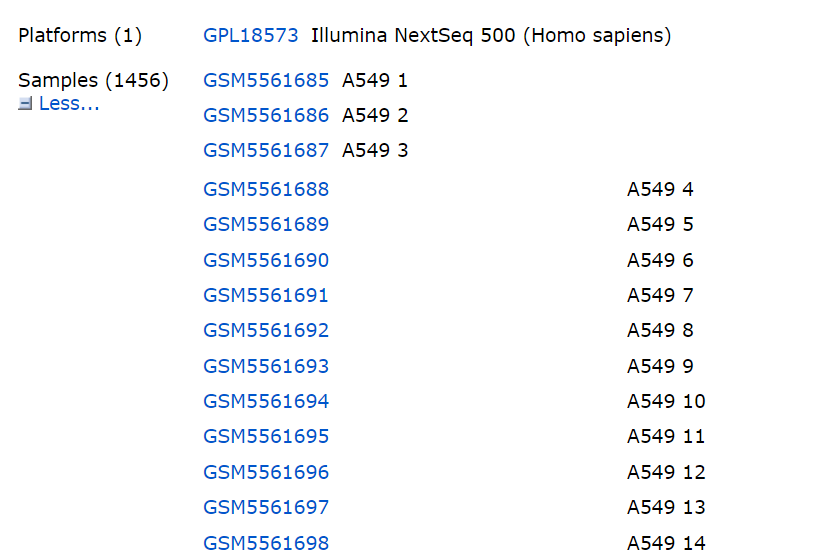

In [10]:
#create the type of the cell
samples<-matrix(1:1456,ncol=1)
samples<-as.data.frame(samples)
rownames(samples)<-colnames(cancer_data)[-1]
celltype<-c(rep("A549",391),rep("H460",(774-391)),rep("H1299",1102-774),rep("Calu",1456-1102))
length(celltype)
samples<-cbind(samples,celltype)
samples[1:10,]

[1] 1456

,V1,celltype
,<int>,<chr>
X0001,1,A549
X0002,2,A549
X0003,3,A549
X0004,4,A549
X0005,5,A549
X0006,6,A549
X0007,7,A549
X0008,8,A549
X0009,9,A549


In [11]:
samples$V1<-NULL
samples[1:10,]

[1] "A549" "A549" "A549" "A549" "A549" "A549" "A549" "A549" "A549" "A549"

The mitochondira gene can be used for qualiy control. However the gene location is not provided in the data matrix, the mitochondria genes were extracted  and dowloaded as "mito.txt" from ensembl database, to check if this dataset has the mitochondria genes.

In [13]:
mtgene<-as.data.frame(read.delim(file="mito.txt", header = TRUE, sep = ","))
mtid<-mtgene[,1]
geneid<-cancer_data$Geneid

mtid
length(mtid)


[1] "ENSG00000210049" "ENSG00000211459" "ENSG00000210077" "ENSG00000210082"
 [5] "ENSG00000209082" "ENSG00000198888" "ENSG00000210100" "ENSG00000210107"
 [9] "ENSG00000210112" "ENSG00000198763" "ENSG00000210117" "ENSG00000210127"
[13] "ENSG00000210135" "ENSG00000210140" "ENSG00000210144" "ENSG00000198804"
[17] "ENSG00000210151" "ENSG00000210154" "ENSG00000198712" "ENSG00000210156"
[21] "ENSG00000228253" "ENSG00000198899" "ENSG00000198938" "ENSG00000210164"
[25] "ENSG00000198840" "ENSG00000210174" "ENSG00000212907" "ENSG00000198886"
[29] "ENSG00000210176" "ENSG00000210184" "ENSG00000210191" "ENSG00000198786"
[33] "ENSG00000198695" "ENSG00000210194" "ENSG00000198727" "ENSG00000210195"
[37] "ENSG00000210196"

[1] 37

In [14]:
geneandmit<-c(geneid,mtid)
length(geneandmit)
length(unique(geneandmit))


[1] 44505

[1] 44505

There is no mitochondira genes in our dataset.

In [15]:
write.table(geneid, file = "geneid.txt", sep = "\t", quote = F, col.names = F,row.names=F)

We only have  ensembl accession number without gene symbl , however the gene symbl does not influence the anlysis here. SO no transformation will be conducted.

In [16]:
#To create the seurat objects
cancer_seurat_obj <- CreateSeuratObject(cancer_data, 
                                            min.cells = ncol(cancer_data)/10,
                                            min.features = 1000)
cancer_seurat_obj


Warning message in storage.mode(from) <- "double":
“NAs introduced by coercion”


An object of class Seurat 
12074 features across 1447 samples within 1 assay 
Active assay: RNA (12074 features, 0 variable features)

In [17]:
cancer_seurat_obj <- AddMetaData(object = cancer_seurat_obj, metadata = samples)

In [18]:
cancer_seurat_obj@meta.data[1:10,]

,orig.ident,nCount_RNA,nFeature_RNA,celltype
,<fct>,<dbl>,<int>,<chr>
X0001,SeuratProject,39920,5592,A549
X0002,SeuratProject,33264,5568,A549
X0003,SeuratProject,36148,5874,A549
X0004,SeuratProject,31128,5124,A549
X0005,SeuratProject,34262,5426,A549
X0006,SeuratProject,30720,5306,A549
X0007,SeuratProject,38057,5378,A549
X0008,SeuratProject,36724,5538,A549
X0009,SeuratProject,28350,5256,A549


# Quality contron and Filtering

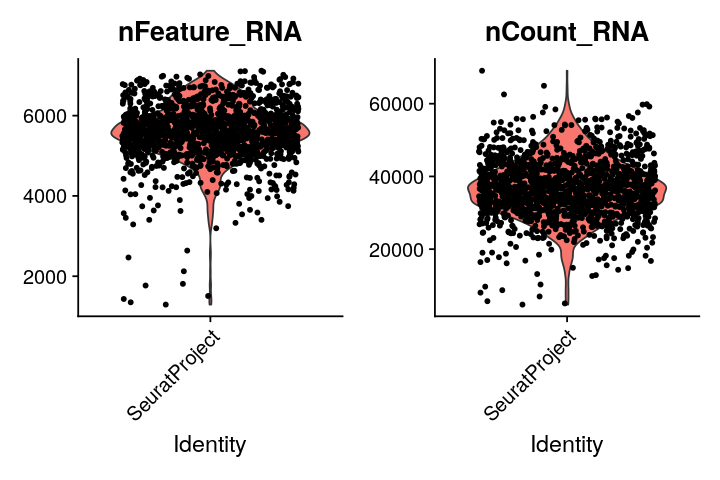

In [19]:
options(repr.plot.width=6, repr.plot.height=4)
VlnPlot(object = cancer_seurat_obj, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

For the RNA n features, several samples with the extremly small number which can be filtered. We can also see majority of the number of features of the RNA are around 6000 and majority of nCount_RNA is aorund 4000.

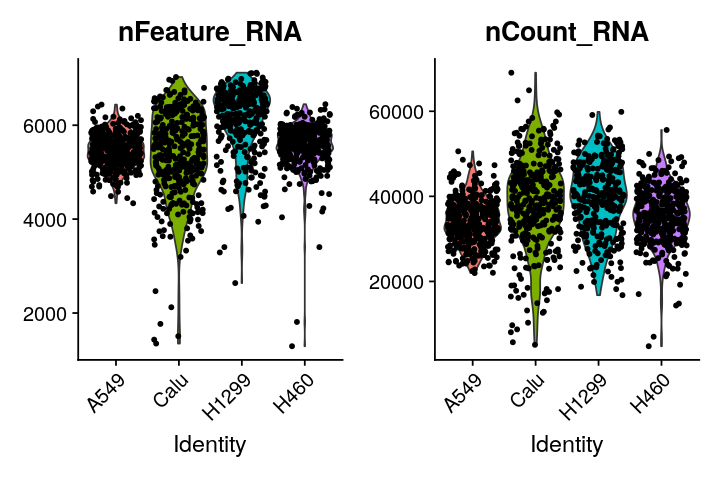

In [20]:
options(repr.plot.width=6, repr.plot.height=4)
VlnPlot(object = cancer_seurat_obj, features = c("nFeature_RNA", "nCount_RNA"), ncol=2,group.by="celltype")

The vlnplot,  the Calu cell line has the wider range for bother nFeture_RNA and nCount_RNA, the A549 has the narrowest range of the both nFeture_RNA and nCount_RNA.

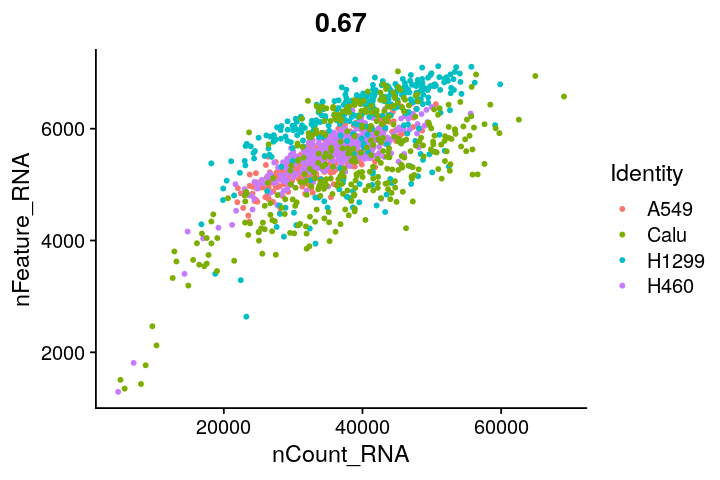

In [21]:
options(repr.plot.width=6, repr.plot.height=4)
FeatureScatter(object = cancer_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "celltype")

Also, the featurescatter plot can show there are some outluers in the lower left corner which may be caused by uninformative cells. 
There is also serval number of points with verg large nCount_RNA which may be due to the doublets.
These abnromal points can be removed to improve the data quality.

In [22]:
#filter the nfeature RNA who is smaller than 2000
cancer_seurat_obj <- subset(cancer_seurat_obj, subset = nFeature_RNA >= 2200&  nCount_RNA>12000 & nCount_RNA<61000)

In [23]:
cancer_seurat_obj

An object of class Seurat 
12074 features across 1436 samples within 1 assay 
Active assay: RNA (12074 features, 0 variable features)

In [24]:
cancer_seurat_obj@assays$RNA@counts[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
                X0001 X0002 X0003 X0004 X0005
ENSG00000228463     .     .     .     .     1
ENSG00000225972    68    63    59    65    38
ENSG00000225630    36    21    20    21    26
ENSG00000237973    98   108   122   103   100
ENSG00000229344    72    79   122    64    75

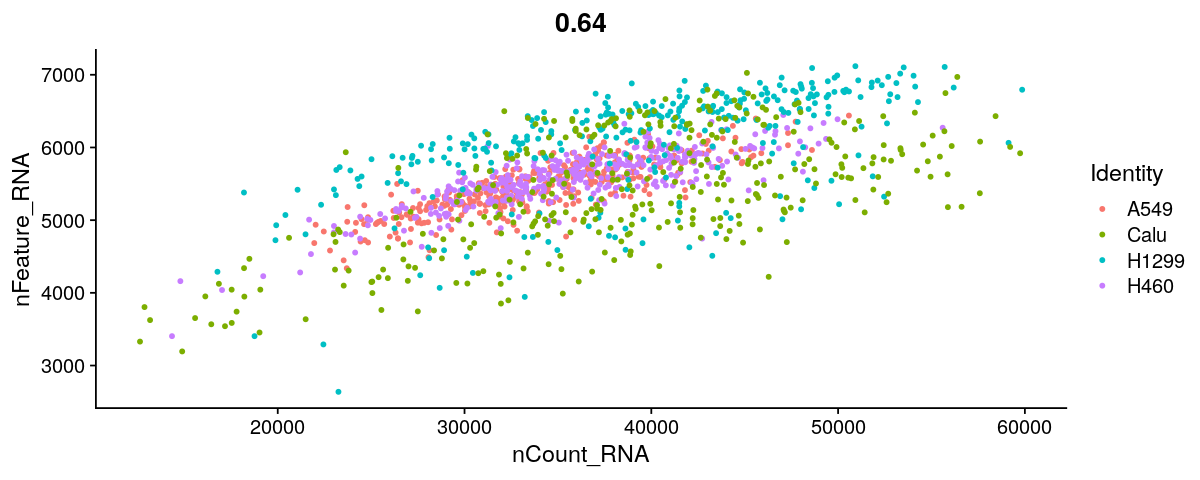

In [25]:
options(repr.plot.width=10, repr.plot.height=4)
plot2 <- FeatureScatter(object = cancer_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "celltype")
plot2

# Normalisation
From the featurescatter, the data from the same types of cell is quite sparse.
Next to normalise our data.

In [26]:
cancer_seurat_obj <- NormalizeData(object = cancer_seurat_obj, normalization.method = "LogNormalize")

In [27]:
cancer_seurat_obj@assays$RNA@data[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
                   X0001    X0002    X0003    X0004     X0005
ENSG00000228463 .        .        .        .        0.2560897
ENSG00000225972 2.892263 2.992697 2.851965 3.085643 2.4924618
ENSG00000225630 2.304387 1.989672 1.876837 2.047220 2.1504337
ENSG00000237973 3.240602 3.510576 3.548184 3.528980 3.4074065
ENSG00000229344 2.946336 3.208801 3.548184 3.070852 3.1307063

To avoid the noise of most genes. Extracting the most varaible gene can be more informative.


In [28]:
cancer_seurat_obj <- FindVariableFeatures(object = cancer_seurat_obj)

In [29]:
top10 <- head(VariableFeatures(cancer_seurat_obj), 10)

When using repel, set xnudge and ynudge to 0 for optimal results



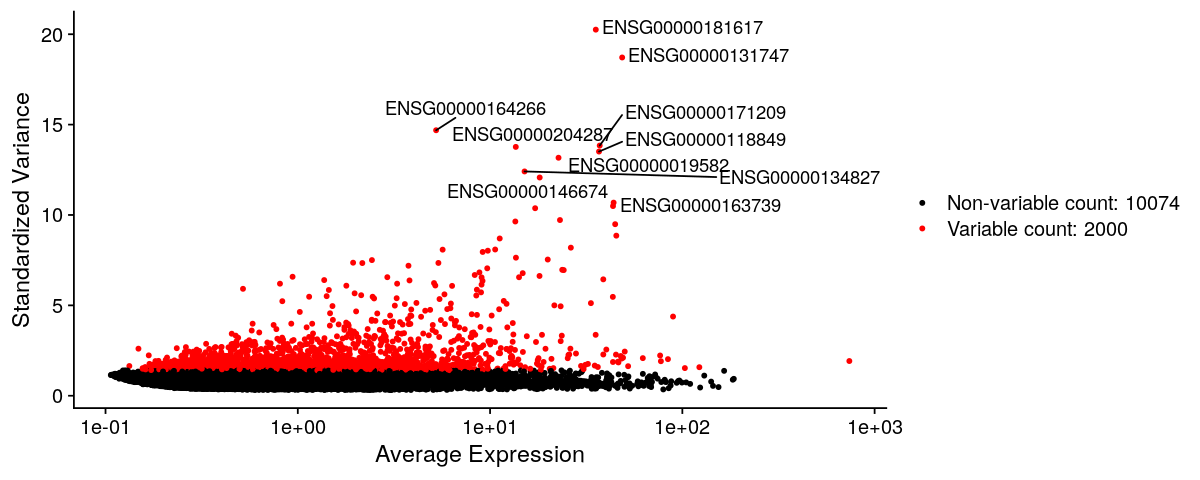

In [30]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- VariableFeaturePlot(cancer_seurat_obj)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

The red points are the variable count.
Next to scale the allgenes before the dimensionality reduction.

In [31]:
all.genes <- rownames(cancer_seurat_obj)
cancer_seurat_obj <- ScaleData(cancer_seurat_obj, features = all.genes)

Centering and scaling data matrix



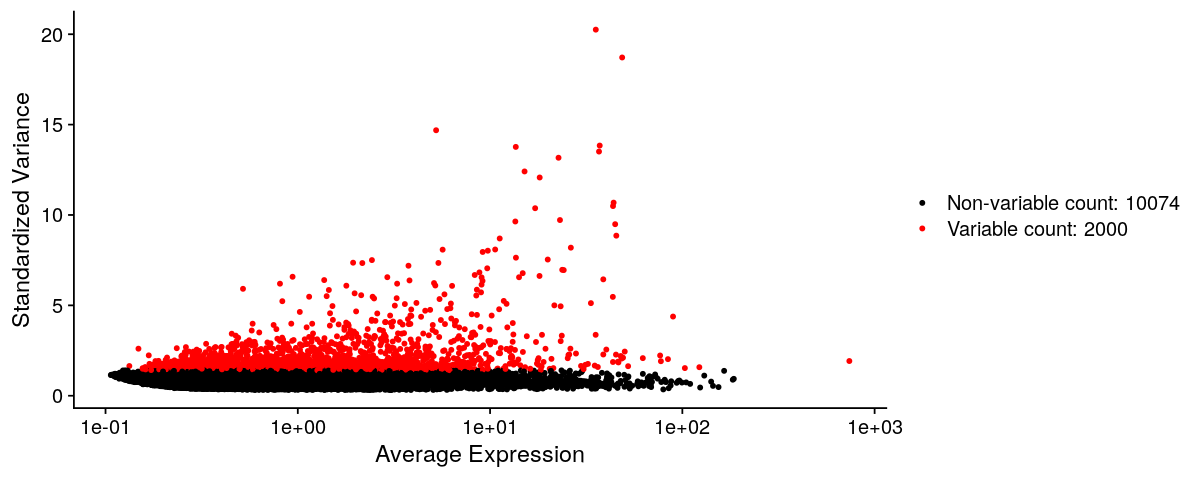

In [32]:
options(repr.plot.width=10, repr.plot.height=4)
plot3<- VariableFeaturePlot(cancer_seurat_obj)
plot3

In [33]:
cancer_seurat_obj@assays$RNA@data[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
                   X0001    X0002    X0003    X0004     X0005
ENSG00000228463 .        .        .        .        0.2560897
ENSG00000225972 2.892263 2.992697 2.851965 3.085643 2.4924618
ENSG00000225630 2.304387 1.989672 1.876837 2.047220 2.1504337
ENSG00000237973 3.240602 3.510576 3.548184 3.528980 3.4074065
ENSG00000229344 2.946336 3.208801 3.548184 3.070852 3.1307063

# Dimesnionality reduction.
To have a look of the cells and genes accosicated with each principle component.

In [34]:
cancer_seurat_obj <- RunPCA(object = cancer_seurat_obj,                                    
                                npcs = 100, nfeatures.print = 5, ndims.print = 1:3)

PC_ 1 
Positive:  ENSG00000119705, ENSG00000182117, ENSG00000100097, ENSG00000026025, ENSG00000167552 
Negative:  ENSG00000118849, ENSG00000141736, ENSG00000171209, ENSG00000100342, ENSG00000172057 
PC_ 2 
Positive:  ENSG00000147381, ENSG00000205777, ENSG00000203989, ENSG00000131721, ENSG00000173809 
Negative:  ENSG00000197956, ENSG00000087086, ENSG00000181019, ENSG00000187134, ENSG00000196139 
PC_ 3 
Positive:  ENSG00000142089, ENSG00000119125, ENSG00000163739, ENSG00000164458, ENSG00000109861 
Negative:  ENSG00000205426, ENSG00000165092, ENSG00000135480, ENSG00000141753, ENSG00000105854 



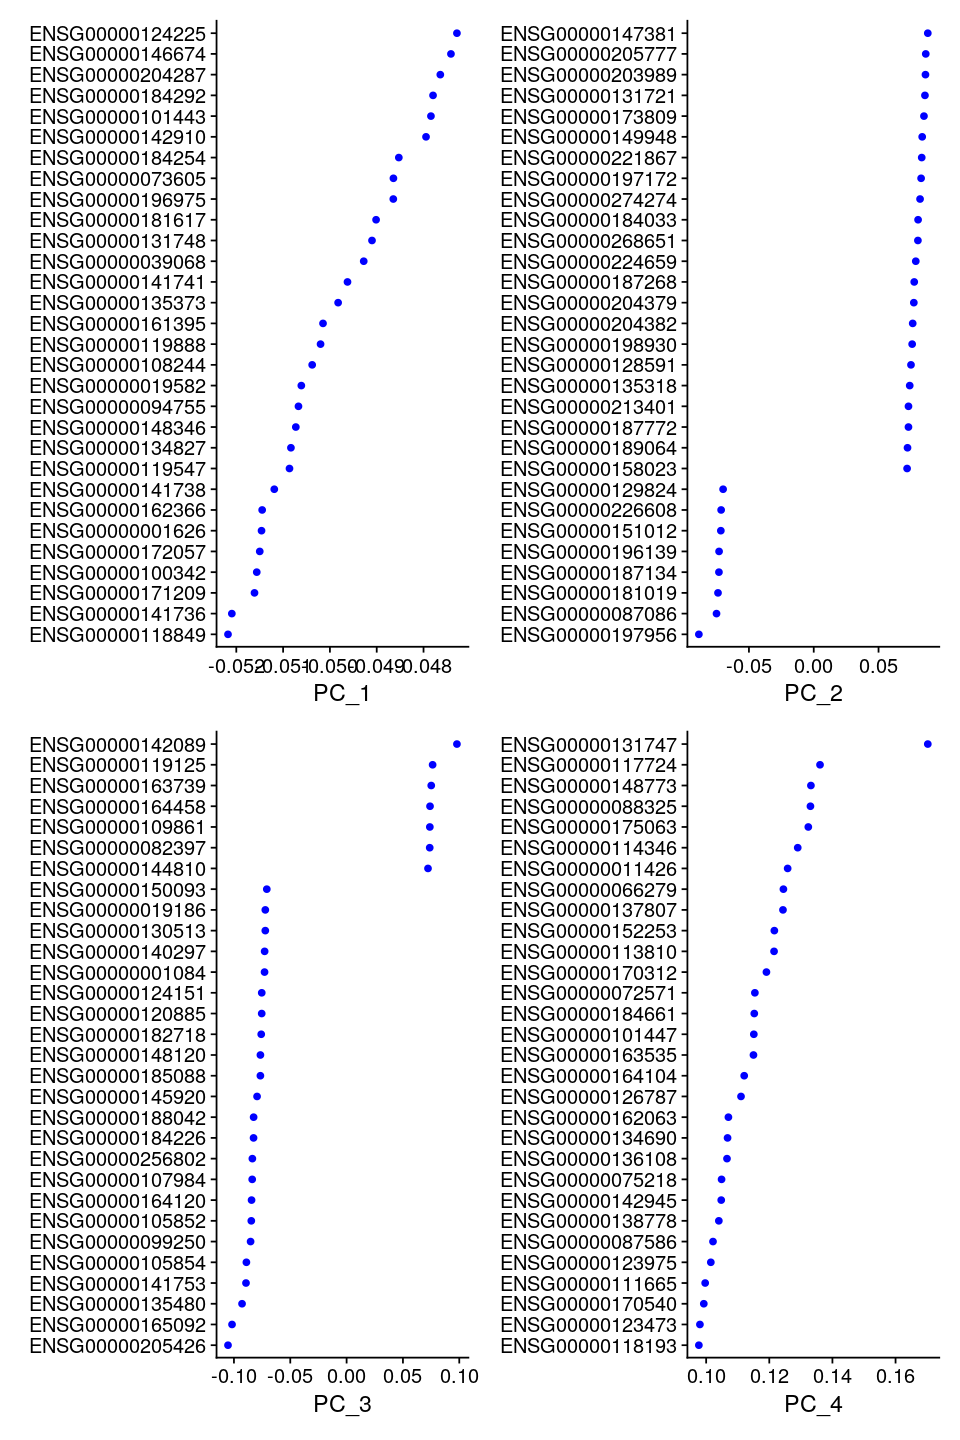

In [35]:
options(repr.plot.width=8, repr.plot.height=12)
VizDimLoadings(cancer_seurat_obj, dims = 1:4, reduction = "pca")

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


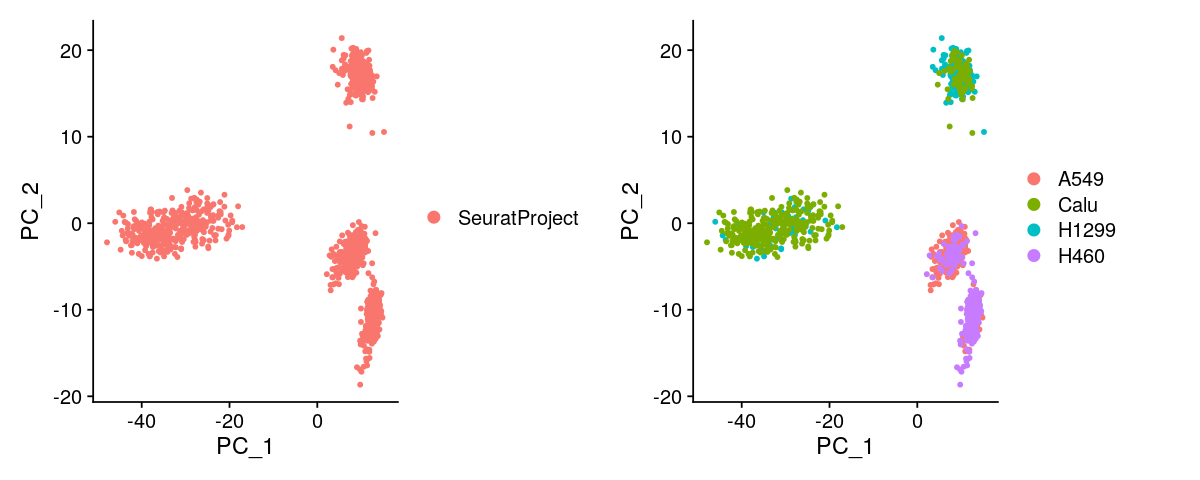

In [36]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(cancer_seurat_obj, reduction = "pca")
plot2 <- DimPlot(cancer_seurat_obj, reduction = "pca", group.by = "celltype")
CombinePlots(plots = list(plot1, plot2))

Four distinct clusters are illustrated here from dimplot which is only using two dimension. From the heatmap of dimplot, the plots are not ideal, the two dimensions are not enough for the dimensional reduction.

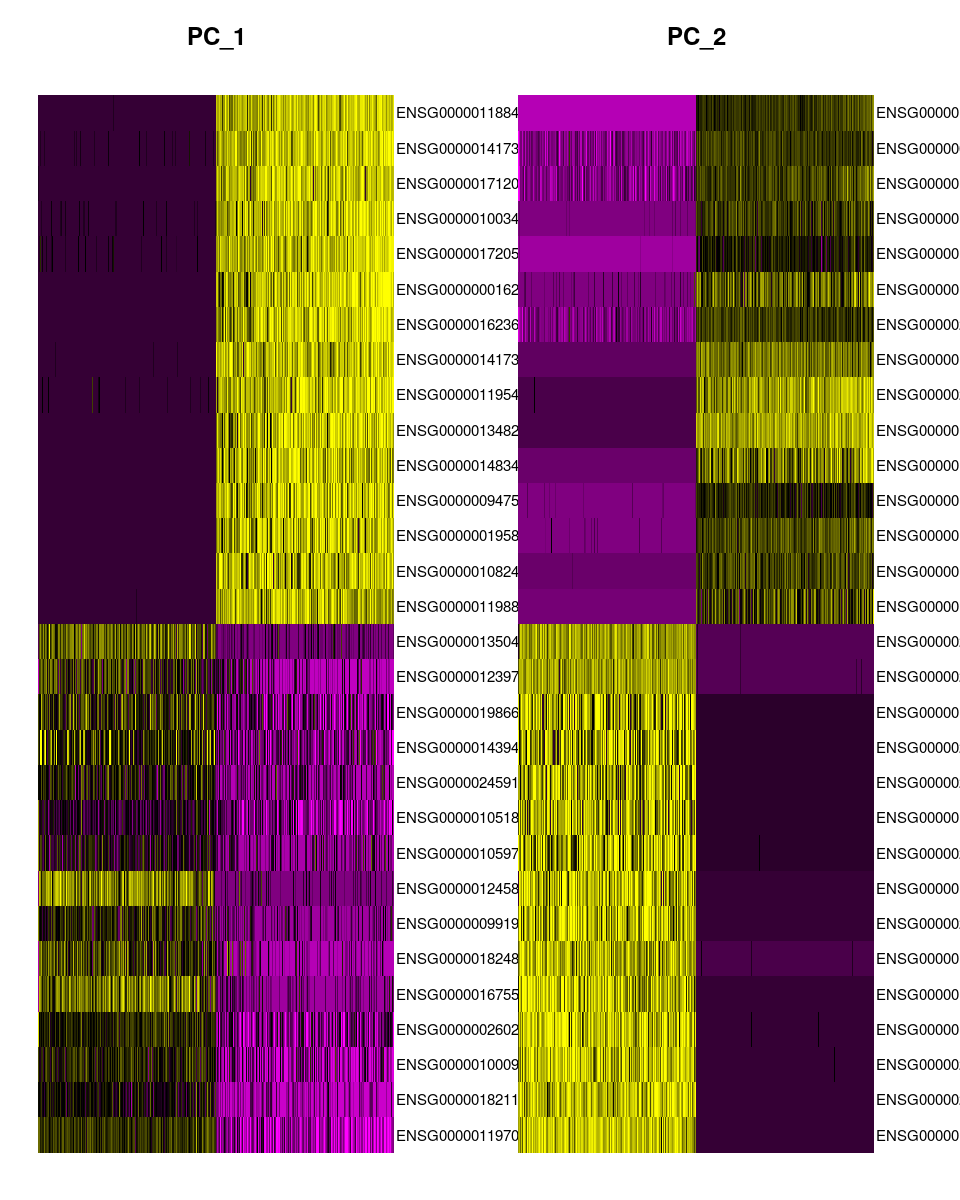

In [37]:
#dimheatmap to visualize the pca score 
options(repr.plot.width=8, repr.plot.height=10)
DimHeatmap(cancer_seurat_obj, dims = 1:2, cells = 500, balanced = TRUE)

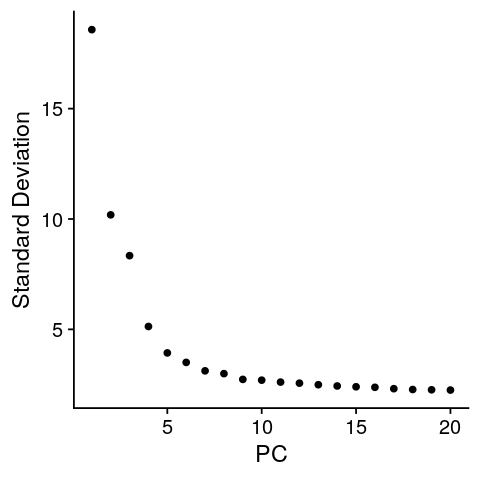

In [38]:
#to find the enough princinple components for clustering
options(repr.plot.width=4, repr.plot.height=4)
ElbowPlot(object = cancer_seurat_obj)

From the elbowplot , when pc=9 capture the majority of the signal. The 10 PCs are selected for the PCA.

In [39]:
cancer_seurat_obj <- FindNeighbors(cancer_seurat_obj, dims = 1:10)
cancer_seurat_obj <- FindClusters(cancer_seurat_obj, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1436
Number of edges: 43990

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8904
Number of communities: 7
Elapsed time: 0 seconds


In [40]:
cancer_seurat_obj@meta.data[1:5,]

,orig.ident,nCount_RNA,nFeature_RNA,celltype,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<fct>,<fct>
X0001,SeuratProject,39920,5592,A549,5,5
X0002,SeuratProject,33264,5568,A549,1,1
X0003,SeuratProject,36148,5874,A549,1,1
X0004,SeuratProject,31128,5124,A549,1,1
X0005,SeuratProject,34262,5426,A549,1,1


Each cells are classified in one cluster.
Next to use non-linear dimensional reduction ,tsNE and UMAP.

In [41]:
#tSNE
cancer_seurat_obj <- RunTSNE(object = cancer_seurat_obj, dims.use = 1:10)
#umap
cancer_seurat_obj <- RunUMAP(cancer_seurat_obj, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:02:13 UMAP embedding parameters a = 0.9922 b = 1.112

11:02:13 Read 1436 rows and found 10 numeric columns

11:02:13 Using Annoy for neighbor search, n_neighbors = 30

11:02:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

11:02:14 Writing NN index file to temp file /tmp/RtmpLj9Tck/file3fe854308c6828

11:02:14 Searching Annoy index using 1 thread, search_k = 3000

11:02:14 Annoy recall = 100%

11:02:14 Commencing smooth kNN distance calibration using 1 thread

11:02:15 Found 4 conne

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


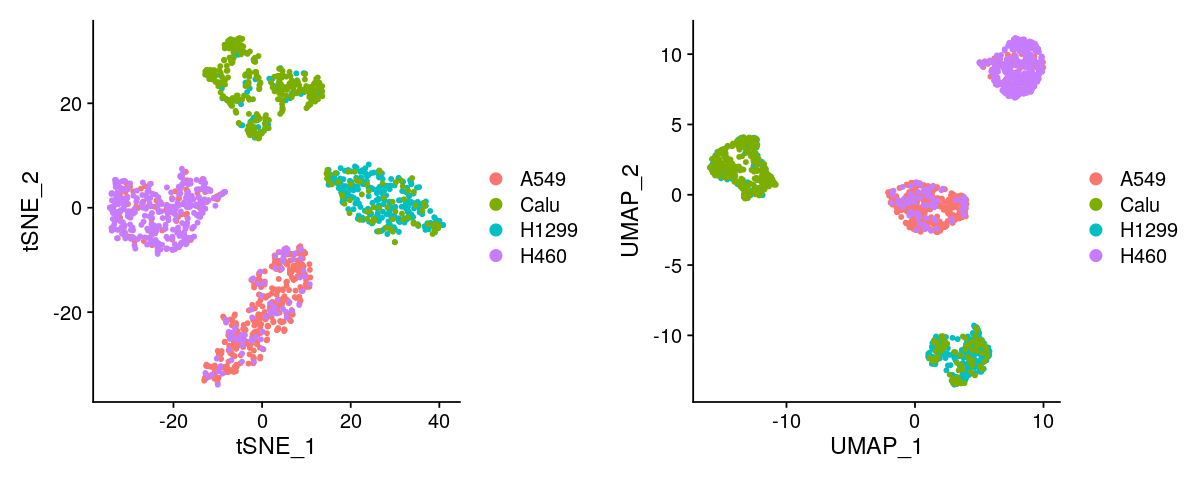

In [42]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(cancer_seurat_obj, reduction = "tsne", group.by = "celltype")
plot2 <- DimPlot(cancer_seurat_obj, reduction = "umap", group.by = "celltype")
CombinePlots(plots = list(plot1, plot2))

There are four distinct clusters and each clusters have two type of cell.

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


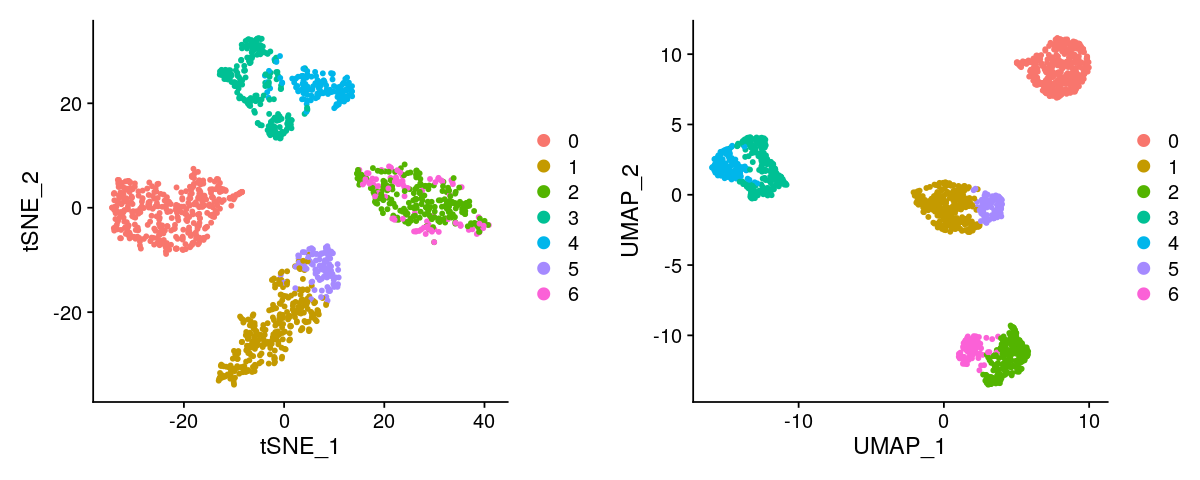

In [43]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- DimPlot(cancer_seurat_obj, reduction = "tsne")
plot2 <- DimPlot(cancer_seurat_obj, reduction = "umap")
CombinePlots(plots = list(plot1, plot2))

If we donnt group the cells, 7 cluster can be detected ,however the cluster 2 and cluster 6 are not clearly seperated. 

Marker discovery
The findall markers can find the marker genes of each cluster comparing with rest parts of genes.

In [44]:
cancer_markers_res0.5 <- FindAllMarkers(object = cancer_seurat_obj, min.pct = 0.25, logfc.threshold = 0.25)

saveRDS(cancer_markers_res0.5, file = "cancer_markers_cluster_res0.5_all.rds.gz", compress = "gzip")

write.table(cancer_markers_res0.5, file = "cancer_markers_res0.5_all.txt", sep = "\t", quote = F, col.names = F)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [45]:
cancer_markers_res0.5[1:10,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
ENSG00000164458,6.292198e-303,1.9988034,0.997,0.001,7.597200e-299,0,ENSG00000164458
ENSG00000082397,1.088432e-298,1.5086952,0.989,0.003,1.314173e-294,0,ENSG00000082397
ENSG00000140937,2.387606e-296,1.5270419,0.979,0.000,2.882795e-292,0,ENSG00000140937
ENSG00000144810,7.516891e-296,1.5466514,0.984,0.003,9.075895e-292,0,ENSG00000144810
ENSG00000254275,5.728107e-284,1.4023646,0.950,0.002,6.916116e-280,0,ENSG00000254275
ENSG00000077264,6.144801e-265,0.9539076,0.905,0.004,7.419232e-261,0,ENSG00000077264
ENSG00000021826,1.826342e-260,1.4806450,0.992,0.057,2.205126e-256,0,ENSG00000021826
ENSG00000179542,2.646441e-259,0.8382244,0.892,0.006,3.195313e-255,0,ENSG00000179542
ENSG00000069482,1.342423e-236,1.2955373,0.984,0.125,1.620841e-232,0,ENSG00000069482


In [46]:
#markers of each genes are displayed here.
cancer_markers_res0.5 %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
7.032795e-195,2.119156,0.974,0.271,8.491396e-191,0,ENSG00000116741
4.104524e-179,2.535175,1.000,0.408,4.955802e-175,0,ENSG00000163739
4.366528e-178,2.306420,1.000,0.198,5.272146e-174,1,ENSG00000205426
2.155766e-140,1.998017,1.000,0.463,2.602872e-136,1,ENSG00000165092
1.833685e-215,1.351359,1.000,0.081,2.213992e-211,2,ENSG00000203989
1.159715e-206,1.397469,1.000,0.081,1.400240e-202,2,ENSG00000147381
8.988411e-177,2.184361,1.000,0.108,1.085261e-172,3,ENSG00000019582
2.837040e-175,2.421988,0.990,0.106,3.425442e-171,3,ENSG00000181617
2.866316e-124,2.023642,1.000,0.158,3.460790e-120,4,ENSG00000001626


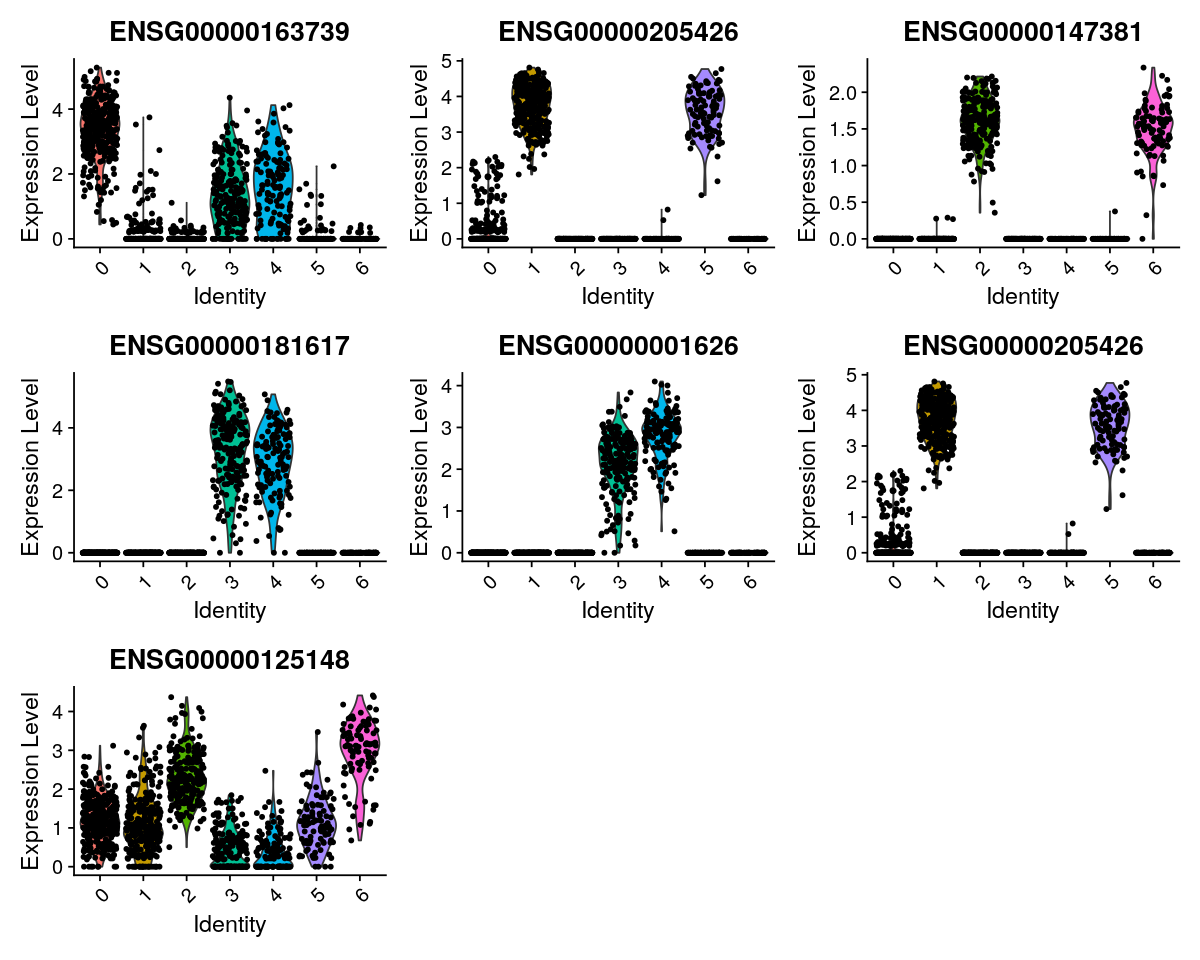

In [47]:
options(repr.plot.width=10, repr.plot.height=8)
cancer_markers_top1 <- cancer_markers_res0.5 %>% group_by(cluster) %>% top_n(n = 1, wt = avg_logFC)
VlnPlot(cancer_seurat_obj, features = cancer_markers_top1$gene)

The top genes of seven clusters.For some genes, cluster 3 and cluster 4 have the same expression pattern and cluster 1 and cluster 5  ,cluster 2 and cluster 6 also have the same pattern. For some genes, some clusters have the unique cluster pattern. 

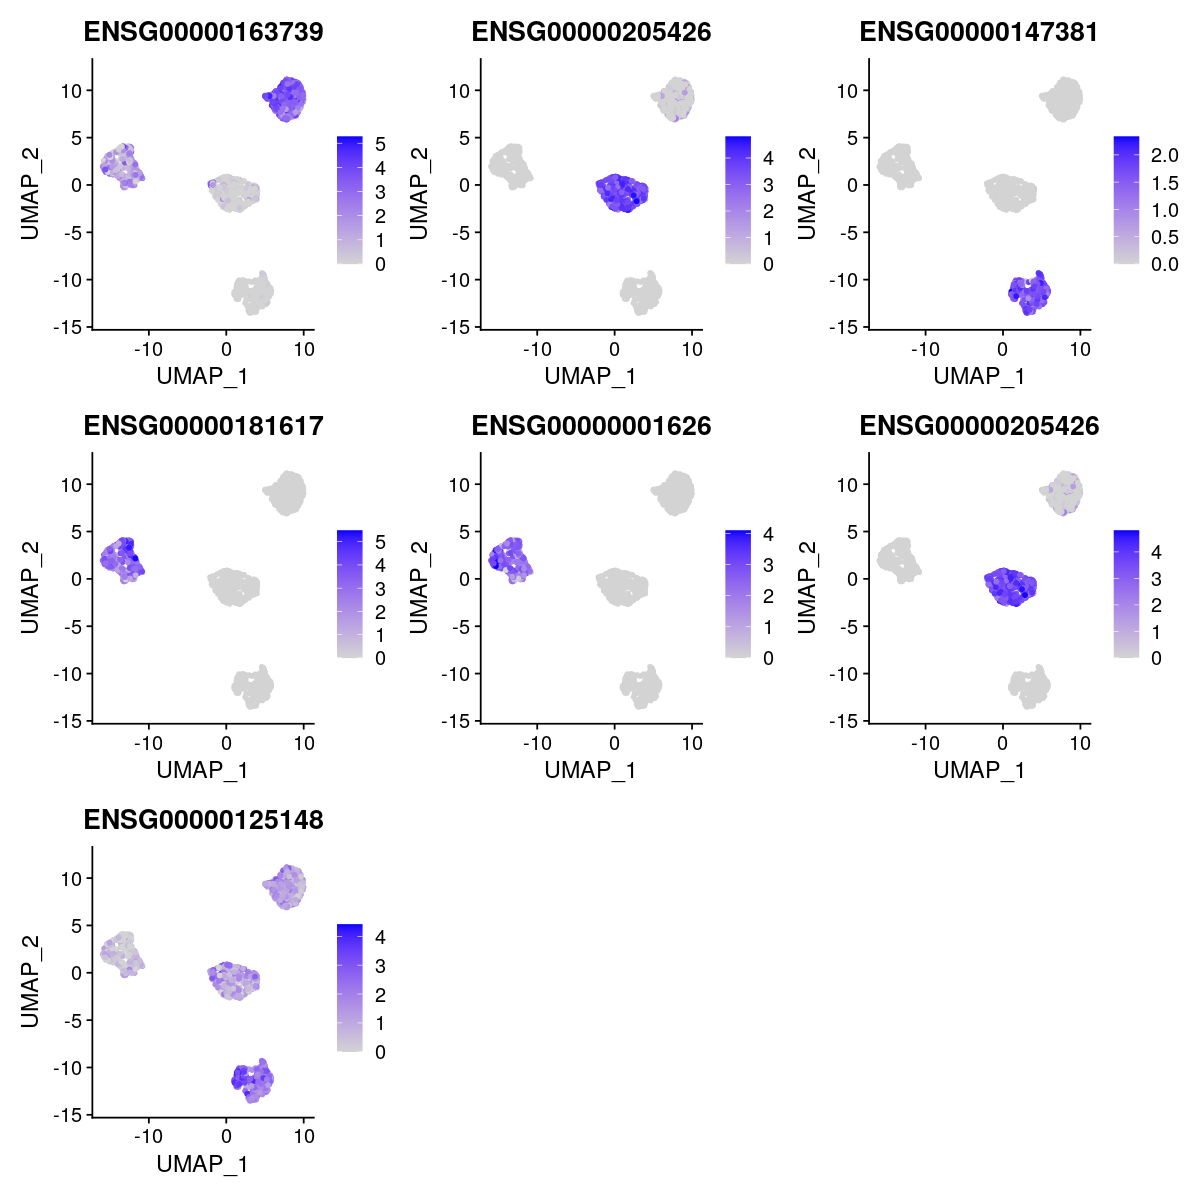

In [48]:
options(repr.plot.width=10, repr.plot.height=10)
FeaturePlot(cancer_seurat_obj, features = cancer_markers_top1$gene)

In [49]:
cancer_markers_top10 <- cancer_markers_res0.5 %>% group_by(cluster) %>% top_n(10, avg_logFC)

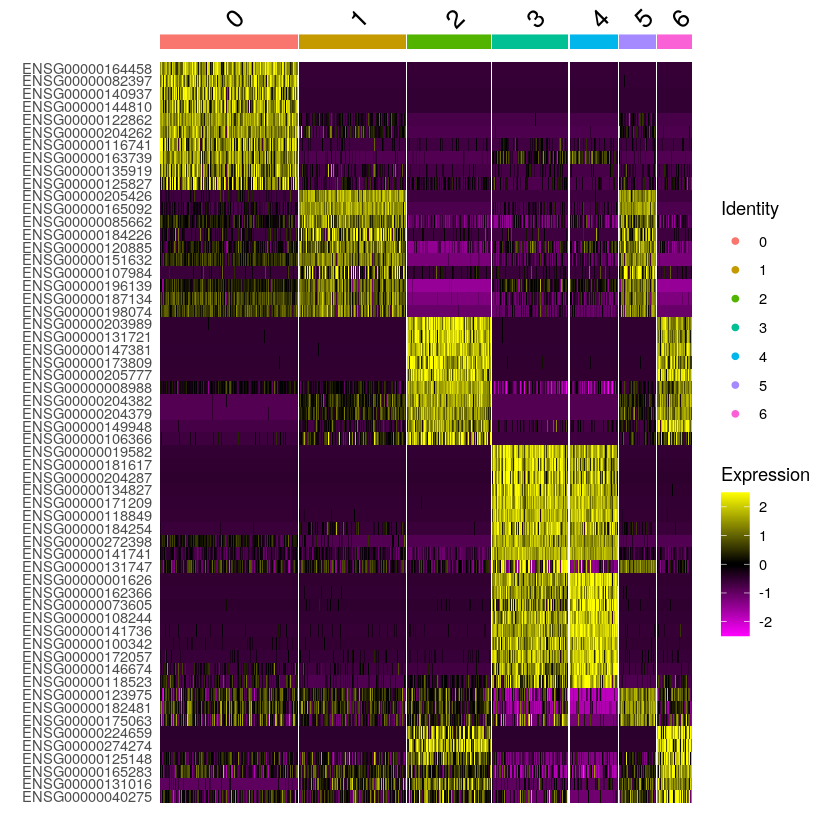

In [50]:
options(repr.plot.width=7, repr.plot.height=7)
DoHeatmap(object = cancer_seurat_obj, features = cancer_markers_top10$gene)

The clutser 3 and clutser 4 have very similar expression pattern , and cluster 2 and cluster 6, cluster1 and cluster 5 also have very simialr patterns,and from the clusters grouped by cell type, we can also know these pairs of clusters are the same type of cells. So we can reduce the resolution to merge some clusters

In [51]:
cancer_seurat_obj <- FindClusters(cancer_seurat_obj, resolution = 0.15)
#reduce the resolution and get the less cluster

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1436
Number of edges: 43990

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9624
Number of communities: 4
Elapsed time: 0 seconds


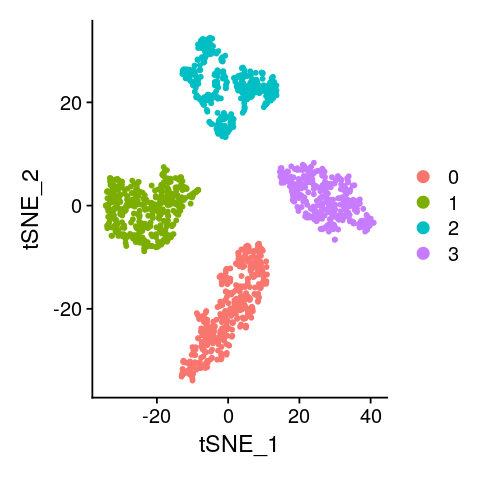

In [52]:
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(cancer_seurat_obj, reduction = "tsne")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



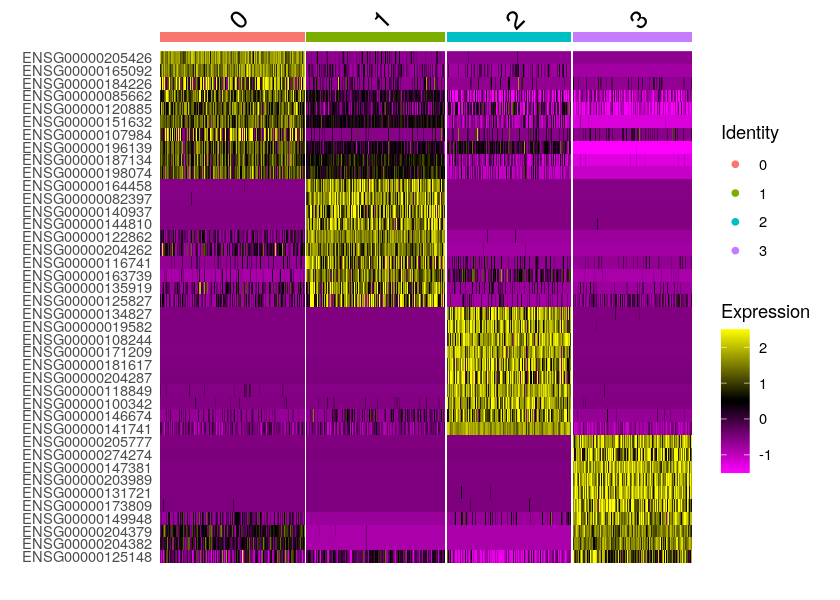

In [53]:
cancer_markers_all <- FindAllMarkers(object = cancer_seurat_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
saveRDS(cancer_markers_all, file = "cancer_markers_cluster_all.e.rds.gz", compress = "gzip")
write.table(cancer_markers_all, file = "cancer_markers_all.txt", sep = "\t", quote = F, col.names = F)

cancer_markers_top10 <- cancer_markers_all %>% group_by(cluster) %>% top_n(10, avg_logFC)
options(repr.plot.width=7, repr.plot.height=5)
DoHeatmap(object = cancer_seurat_obj, features = cancer_markers_top10$gene)

The expression patterns and different for each cluster,and each cluster has some highly expression genes. We will use four clusters to do the analysis next. 

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


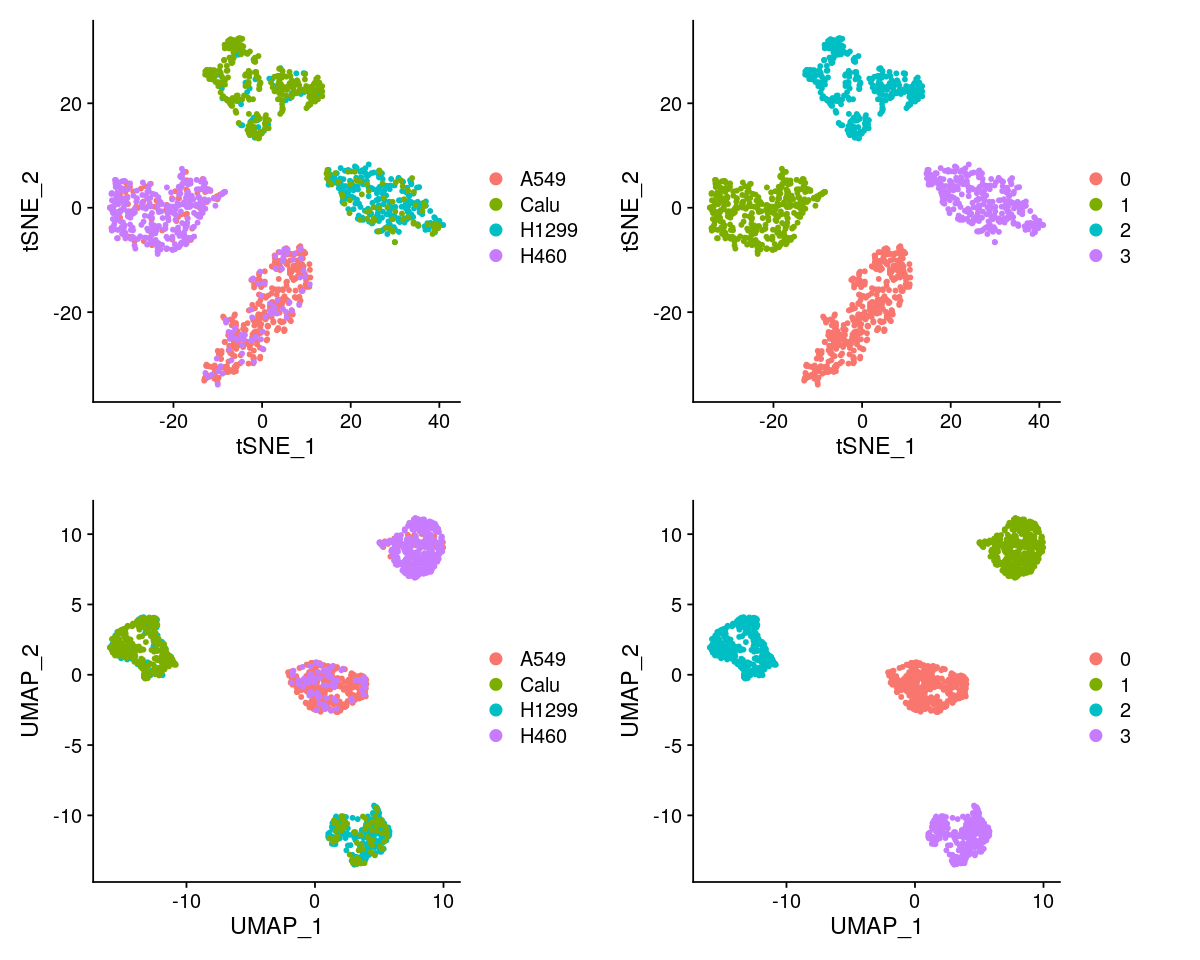

In [54]:
options(repr.plot.width=10, repr.plot.height=8)
plot1 <- DimPlot(cancer_seurat_obj, reduction = "tsne", group.by = "celltype")
plot2 <- DimPlot(cancer_seurat_obj, reduction = "tsne")
plot3 <- DimPlot(cancer_seurat_obj, reduction = "umap", group.by = "celltype")
plot4 <- DimPlot(cancer_seurat_obj, reduction = "umap")
CombinePlots(plots = list(plot1, plot2, plot3, plot4))

The clustering is close to the orignial paper, There is some difference in the composition of cluster 0, the cluster 0 has four cell types in the orgnial papaers.
The difference is due to they used SC3 clustering tool.

In [55]:
#to calculate, how many different types of cells in each cluster.
cluster<-cancer_seurat_obj@meta.data[,c("seurat_clusters","celltype")]
celltypes<-c("A549","Calu","H1299","H460")
clus<-c(0,1,2,3)
# To count how many cells in each cluster
lapply(clus,function(x) sum(apply(cluster,1,function(y) y[1]==x)))   

[[1]]
[1] 394

[[2]]
[1] 378

[[3]]
[1] 340

[[4]]
[1] 324

Here we can see the exact number of different cedlls.

In [56]:
#to count the number of each type of cell in each cluster
lapply(celltypes,function(x) lapply(clus,function(y) sum( cluster[cluster$seurat_cluster==y,]==x)))                

[[1]]
[[1]][[1]]
[1] 317

[[1]][[2]]
[1] 74

[[1]][[3]]
[1] 0

[[1]][[4]]
[1] 0


[[2]]
[[2]][[1]]
[1] 0

[[2]][[2]]
[1] 0

[[2]][[3]]
[1] 272

[[2]][[4]]
[1] 73


[[3]]
[[3]][[1]]
[1] 0

[[3]][[2]]
[1] 0

[[3]][[3]]
[1] 68

[[3]][[4]]
[1] 251


[[4]]
[[4]][[1]]
[1] 77

[[4]][[2]]
[1] 304

[[4]][[3]]
[1] 0

[[4]][[4]]
[1] 0

For cluster 1, it includes 317 A549  and 74 Calu.
For cluster 2 it includes 272 H1299 and 73 H460.
For cluster 3, it includes 68 H1299 and 251 H460.
For cluster 4, it contains 77 A549 and 304 Calu.


#To find the marker genes of each two cluster
In this situation , use the cluster 0 as the reference cluster to compare with other cluster
as it is in the middle of the plot
how to set the threshold

The cluster 0 is set as the reference, we can compare other clusters with cluster 0.

In [57]:
cancer_markers_0v1<- FindMarkers(cancer_seurat_obj, ident.1 = 0, ident.2 = 1, 
                                 only.pos = FALSE, min.pct = 0.0, logfc.threshold = 0.0)
nrow(cancer_markers_0v1)
cancer_markers_0v1 <- cancer_markers_0v1[order(cancer_markers_0v1$avg_logFC, decreasing = T),]
head(cancer_markers_0v1,n=10)
write.table(cancer_markers_0v1, file = "cancer_markers_0v1.txt", sep = "\t", quote = F, col.names = T,row.names=T)


[1] 12011

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000205426,4.498876e-132,3.369368,1.000,0.325,5.431943e-128
ENSG00000165092,1.056592e-127,2.580060,1.000,0.735,1.275729e-123
ENSG00000176153,9.460778e-90,2.124594,0.754,0.040,1.142294e-85
ENSG00000135480,5.998781e-132,1.993071,1.000,0.341,7.242928e-128
ENSG00000019186,4.005079e-138,1.783844,1.000,0.130,4.835732e-134
ENSG00000167642,9.531322e-142,1.438470,0.995,0.026,1.150812e-137
ENSG00000107984,1.096644e-92,1.427532,0.848,0.143,1.324088e-88
ENSG00000131016,2.386730e-111,1.398485,0.929,0.161,2.881738e-107
ENSG00000188042,8.746443e-126,1.355841,0.937,0.042,1.056046e-121


In [58]:
cancer_markers_0v2<- FindMarkers(cancer_seurat_obj, ident.1 = 0, ident.2 = 2, 
                                 only.pos = FALSE, min.pct = 0.0, logfc.threshold = 0.0)
nrow(cancer_markers_0v2)
write.table(cancer_markers_0v2, file = "cancer_markers_0v2.txt", sep = "\t", quote = F, col.names = T,row.names=T)

[1] 12051

In [59]:
cancer_markers_0v3<- FindMarkers(cancer_seurat_obj, ident.1 = 0, ident.2 = 3, 
                                 only.pos = FALSE, min.pct = 0.0, logfc.threshold = 0.0)
nrow(cancer_markers_0v3)
write.table(cancer_markers_0v3, file = "cancer_markers_0v3.txt", sep = "\t", quote = F, col.names = T,row.names=T)

[1] 12030

In [60]:
head(cancer_markers_0v3)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000203989,3.902950e-140,-1.440905,0.000,0.997,4.712422e-136
ENSG00000205777,3.902974e-140,-1.677463,0.000,0.997,4.712451e-136
ENSG00000131721,4.391902e-140,-1.413395,0.008,1.000,5.302783e-136
ENSG00000274274,1.722793e-139,-1.366185,0.000,0.994,2.080100e-135
ENSG00000147381,2.713233e-139,-1.618688,0.010,0.997,3.275958e-135
ENSG00000170627,1.446498e-137,-1.133545,0.000,0.985,1.746501e-133


In [61]:
cancer_seurat_obj

An object of class Seurat 
12074 features across 1436 samples within 1 assay 
Active assay: RNA (12074 features, 2000 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

In [62]:
cancer_markers_all_genes <- FindAllMarkers(cancer_seurat_obj,
                                              only.pos = F, 
                                              min.pct  = 0, 
                                              return.thresh = 1, 
                                              logfc.threshold = 0)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [63]:
dim(cancer_markers_all_genes)
head(cancer_markers_all_genes)
write.table(cancer_markers_all_genes, file = "cancer_markers_all_genes.txt", sep = "\t", quote = F, col.names = T,row.names=T)

[1] 48296     7

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
ENSG00000205426,9.266923e-254,3.6445291,1.000,0.120,1.118888e-249,0,ENSG00000205426
ENSG00000165092,6.137856e-204,2.8148913,1.000,0.411,7.410848e-200,0,ENSG00000165092
ENSG00000164120,2.383188e-198,1.0676124,0.769,0.028,2.877461e-194,0,ENSG00000164120
ENSG00000145920,1.074451e-194,0.8915730,0.739,0.016,1.297293e-190,0,ENSG00000145920
ENSG00000141753,6.065018e-185,0.9944333,0.924,0.183,7.322902e-181,0,ENSG00000141753
ENSG00000184226,1.302023e-172,1.2621165,0.924,0.247,1.572062e-168,0,ENSG00000184226


The  ranked markers of 3 clusters  are extracted based on averge log fold change

In [64]:

cancer_loom <- build_loom(file.name = "cancer_seurat_obj.loom", 
                        dgem = as.matrix(cancer_seurat_obj[["RNA"]]@counts),
                        title = "lung Cancer Dataset",
                        genome="Human",
                        default.embedding = cancer_seurat_obj@reductions$tsne@cell.embeddings,
                        default.embedding.name = "tSNE on variable genes")


add_col_attr(cancer_loom, key = "celltype",
                value = as.vector(cancer_seurat_obj@meta.data$celltype),
                as.annotation = T)
add_col_attr(cancer_loom, key = "clusters",
                value = as.vector(cancer_seurat_obj@meta.data$seurat_clusters),
                as.annotation = T)
marker_file_list <- list(
    RNA_snn_res.0.5 = "cancer_markers_cluster_res0.5_all.rds.gz")

add_seurat_clustering(cancer_loom, 
                      seurat = cancer_seurat_obj,
                      seurat.assay = "RNA",
                      default.clustering.resolution = 0.15,
                      seurat.clustering.prefix = "RNA_snn_res.",
                      seurat.markers.file.path.list = marker_file_list)
finalize(cancer_loom)

[1] "Adding global attributes..."
[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns graphs..."
[1] "Adding row graphs..."
[1] "Adding layers..."
[1] "Seurat, RNA_snn_res.0.5"
[1] "Adding Seurat clusters..."
[1] "Clusterings created..."
[1] "Clustering ID: 0"
[1] "Adding Seurat markers..."
[1] "Adding markers for clustering 0..."
[1] "Seurat, RNA_snn_res.0.15"
[1] "Adding Seurat clusters..."
[1] "Adding default Seurat clusters..."
[1] "Clusterings already exists..."
[1] "Clustering ID: 1"
[1] "Adding Seurat markers..."


Warning message in add_seurat_clustering(cancer_loom, seurat = cancer_seurat_obj, :
“Seurat markers for clustering resolution 0.15 have not been computed.”


The loom is displayed on scope with four distinct cluster with mix of cell types.
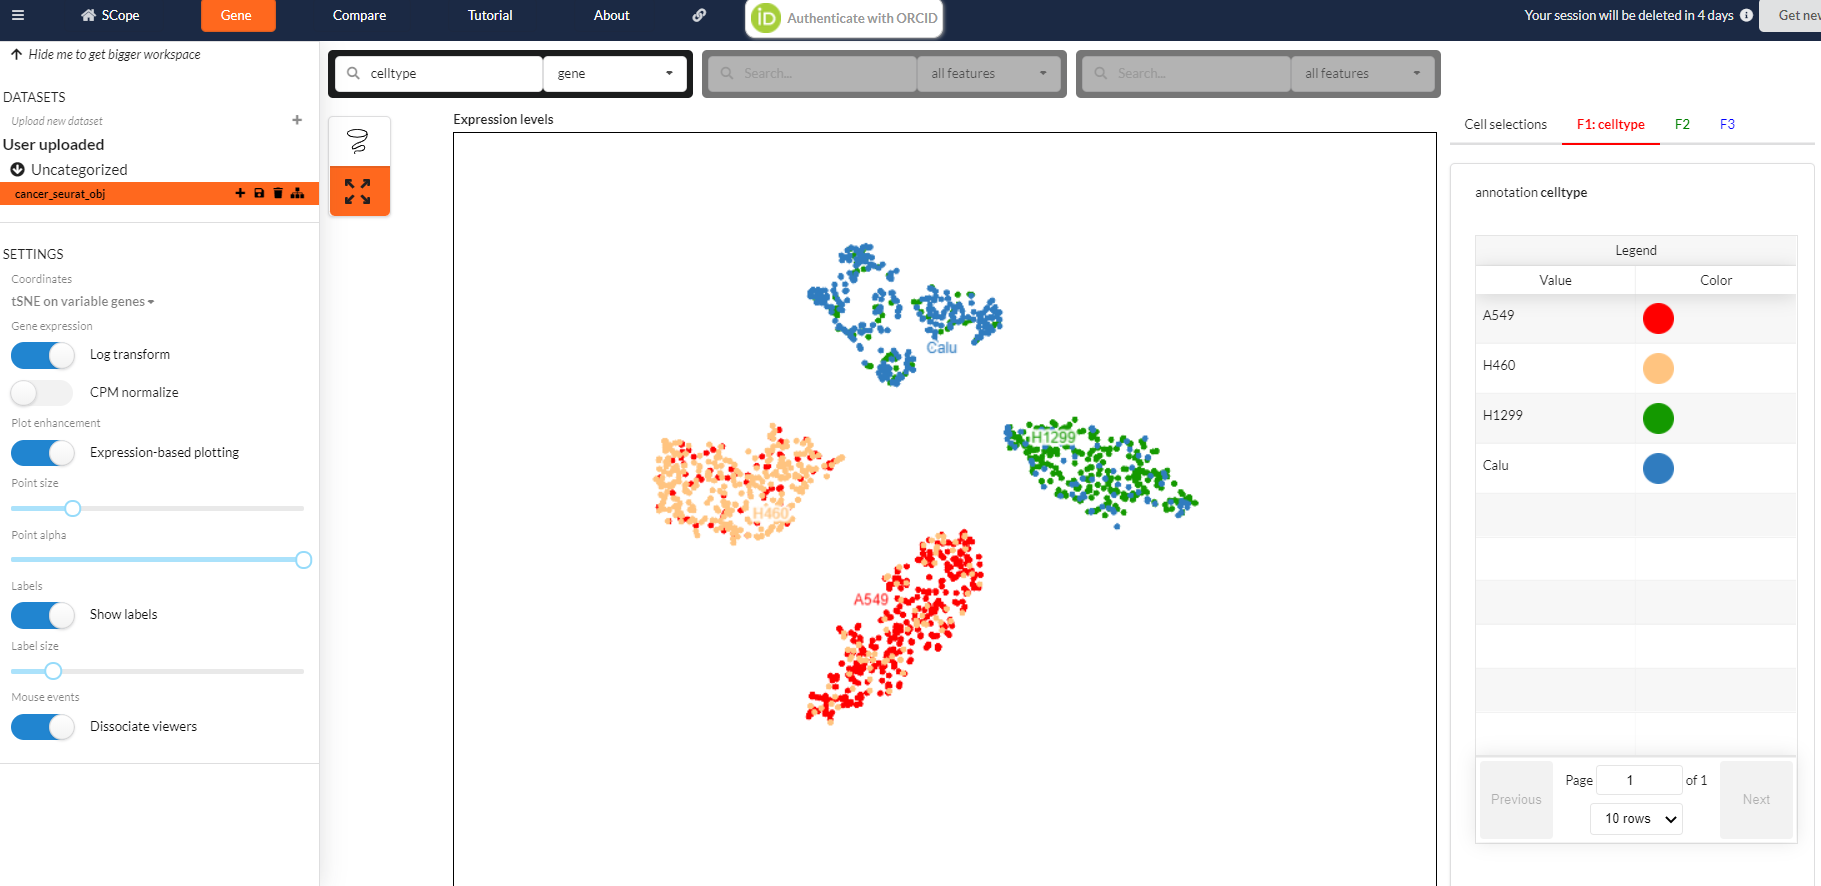

In [65]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] plyr_1.8.6        IRdisplay_0.7.0   SCopeLoomR_0.10.1 Matrix_1.2-18    
[5] dplyr_1.0.2       Seurat_3.2.2     

loaded via a namespace (and not attached):
  [1] nlme_3.1-149          matrixStats_0.57.0    bit64_4.0.5          
  [4] RcppAnnoy_0.0.16      RColorBr

Next to do the functional analysis using the extracted marker genes, the function analysis can be found at DING_functional analysis.ipynb